<div style="display: flex; align-items: center;">
    <img src="https://github.com/nagelt/Teaching_Scripts/raw/9d9e29ecca4b04eaf7397938eacbf116d37ddc93/Images/TUBAF_Logo_blau.png" width="500" height="auto" height="auto" style="margin-right: 100px;" />
    <div>
        <p><strong>Prof. Dr. Thomas Nagel</strong></p>
        <p>Chair of Soil Mechanics and Foundation Engineering<br>Geotechnical Institute<br>Technische Universität Bergakademie Freiberg.</p>
        <p><a href="https://tu-freiberg.de/en/soilmechanics">https://tu-freiberg.de/en/soilmechanics</a></p>
    </div>
</div>

# Stress paths for simple constitutive models of soils

Review the lecture material on basics of elasto-plastic models from the course Foundations of Soil Mechanics.

In [1]:
#HIDDEN
import numpy as np
import matplotlib.pyplot as plt #plotting
import sympy as sp
sp.init_printing(use_latex='mathjax') #makes sympy output look nice
import os
import mtest
import tfel.math

In [2]:
import plot_settings
%run stress_path_defs.ipynb

In [3]:
#HIDDEN
build_release = 'mfront --obuild --interface=generic MohrCoulombAbboSloan.mfront'
#os.system(build_release)

In [4]:
#HIDDEN
build_release = 'mfront --obuild --interface=generic ModCamClay_semiExpl.mfront'
#os.system(build_release)

## Preliminary considerations

We limit ourselves to the consideration of principal stresses here, following the geomechanical sign convention as well as $\sigma_1 \geq \sigma_2 \geq \sigma_3$. Without loss of generality we write

$$
    \sigma_{ij} =
    \begin{pmatrix}
        \sigma_1 & 0 & 0 \\
        0 & \sigma_2 & 0 \\
        0 & 0 & \sigma_3
    \end{pmatrix}
$$

for the stress tensor and

$$
    \sigma_{ij}^\text{D} = \frac{1}{3}
    \begin{pmatrix}
        2\sigma_1 - \sigma_2 - \sigma_3 & 0 & 0 \\
        0 & 2\sigma_2 - \sigma_1 - \sigma_3 & 0 \\
        0 & 0 & 2\sigma_3 - \sigma_1 - \sigma_2
    \end{pmatrix}
$$

for its deviator.

We further introduce the invariants $p$ and $q$ with

\begin{align}
    p &= \frac{1}{3} \sigma_{ii} = \frac{\sigma_1 + \sigma_2 + \sigma_3}{3}
    \\
    q & = \sqrt{\frac{3}{2} \sigma^\text{D}_{ij} \sigma^\text{D}_{ij}}
\end{align}

Let's run some symbolic calculations.

In [5]:
#HIDDEN
s1, s2, s3 = sp.symbols('sigma_1 sigma_2 sigma_3')

In [6]:
sig = sp.Matrix([[s1,0,0],[0,s2,0],[0,0,s3]])
display("sigma_{ij}", sig)

'sigma_{ij}'

⎡σ₁  0   0 ⎤
⎢          ⎥
⎢0   σ₂  0 ⎥
⎢          ⎥
⎣0   0   σ₃⎦

In [7]:
sigD = sig - sp.Rational('1/3')*sp.trace(sig) * sp.eye(3)
display("sigma^D_{ij}", sigD)

'sigma^D_{ij}'

⎡2⋅σ₁   σ₂   σ₃                                    ⎤
⎢──── - ── - ──         0                 0        ⎥
⎢ 3     3    3                                     ⎥
⎢                                                  ⎥
⎢                  σ₁   2⋅σ₂   σ₃                  ⎥
⎢      0         - ── + ──── - ──         0        ⎥
⎢                  3     3     3                   ⎥
⎢                                                  ⎥
⎢                                    σ₁   σ₂   2⋅σ₃⎥
⎢      0                0          - ── - ── + ────⎥
⎣                                    3    3     3  ⎦

In [8]:
q = sp.sqrt(sp.Rational('3/2') * sp.tensorcontraction(sigD*sigD,(0,1)))
display("q", q.simplify())

'q'

   _________________________________________
  ╱   2                     2             2 
╲╱  σ₁  - σ₁⋅σ₂ - σ₁⋅σ₃ + σ₂  - σ₂⋅σ₃ + σ₃  

Thus, by applying the second binomial equation we arrive at

$$
    q = \frac{1}{\sqrt{2}} \sqrt{(\sigma_1 - \sigma_2)^2 + (\sigma_1 - \sigma_3)^2 + (\sigma_2 - \sigma_3)^2}
$$

Now let's take a look at standard triaxial tests, where $\sigma_1 \geq \sigma_2 = \sigma_3$ for triaxial compression and $\sigma_1 = \sigma_2 \geq \sigma_3$ for triaxial extension.

Therefore,

$$
    p_\text{triax} =  \begin{cases}
        \displaystyle \frac{\sigma_1 + 2 \sigma_3}{3} & \text{triax. comp.}
        \\\\
        \displaystyle \frac{2 \sigma_1 + \sigma_3}{3} & \text{triax. ext.}
    \end{cases}
$$

In [9]:
q_comp = q.subs(s2,s3)
display(sp.simplify(q_comp))

   ____________
  ╱          2 
╲╱  (σ₁ - σ₃)  

In [10]:
q_ext = q.subs(s2,s1)
display(sp.simplify(q_ext))

   ____________
  ╱          2 
╲╱  (σ₁ - σ₃)  

Thus, using the sign convention introduced above, the deviatoric invariant $q$ is identical and equal to

$$
    q_\text{triax} = \sigma_1 - \sigma_3
$$

## The Mohr-Coulomb model

The yield surface of the Mohr-Coulomb model formulated in principal stresses reads:

$$
    \frac{\sigma_1 - \sigma_3}{2} = \frac{\sigma_1 + \sigma_3}{2} \sin \varphi + c \cos \varphi
$$

so that the axial failure load follows

$$
    \sigma_\text{ax,f} = \begin{cases}
        \displaystyle \frac{1 + \sin \varphi}{1 - \sin \varphi} p_\text{conf} + \frac{2c \cos \varphi}{1 - \sin\varphi} & \text{triax. compr.}
        \\\\
        \displaystyle \frac{1 - \sin \varphi}{1 + \sin \varphi} p_\text{conf} - \frac{2c \cos \varphi}{1 + \sin\varphi} & \text{triax. ext.}
    \end{cases}
$$

We know these equations from the active and passive Rankine earth pressures.

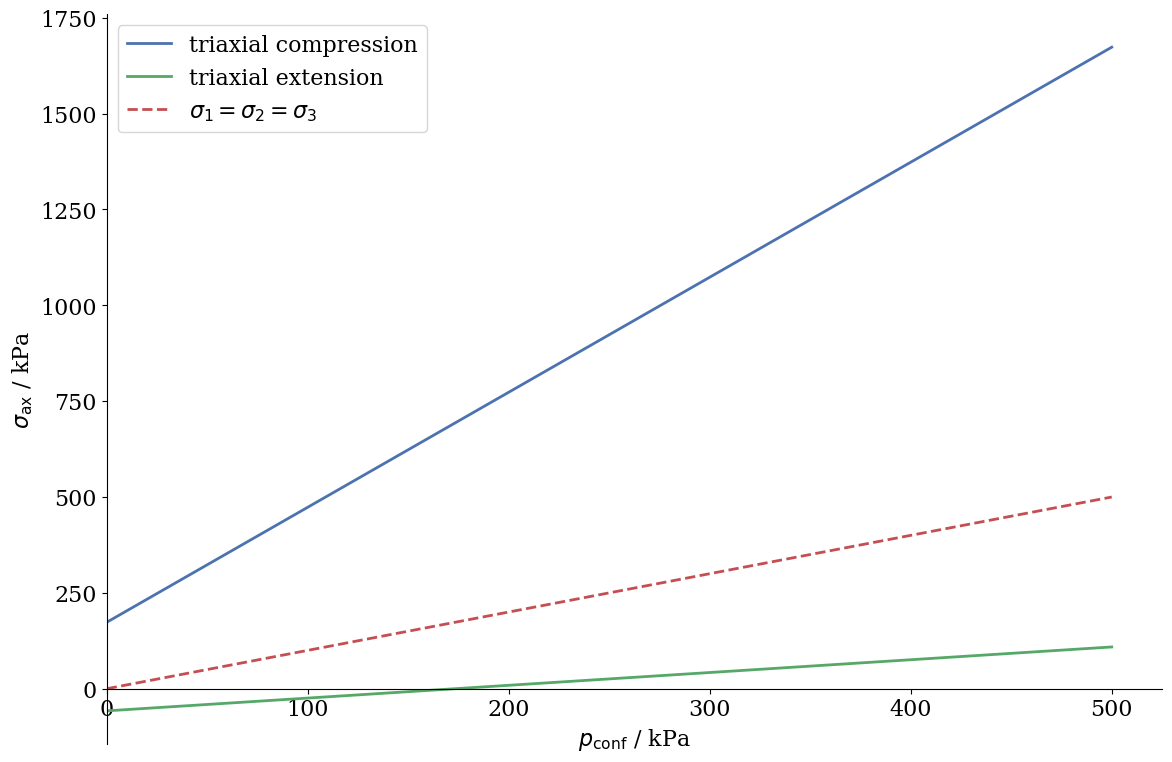

In [11]:
#HIDDEN
conf = np.linspace(0,500,10)
s_ax_comp = lambda phi, c, sig3: ((1+np.sin(phi)) * sig3 + 2*c*np.cos(phi))/(1-np.sin(phi))
s_ax_ext = lambda phi, c, sig1: ((1-np.sin(phi)) * sig1 - 2*c*np.cos(phi))/(1+np.sin(phi))
fig, ax = plt.subplots(figsize=(12,8))
ax.plot(conf,s_ax_comp(np.deg2rad(30),50,conf),label='triaxial compression')
ax.plot(conf,s_ax_ext(np.deg2rad(30),50,conf),label='triaxial extension')
ax.plot(conf,conf,ls='--',label='$\\sigma_1 = \sigma_2 = \sigma_3$')
ax.spines['bottom'].set_position(('data', 0))
ax.set_xlim(left=0)
#ax.set_ylim(bottom=0)
ax.set_ylabel('$\sigma_\\mathrm{ax}$ / kPa')
ax.set_xlabel('$p_\\mathrm{conf}$ / kPa')
ax.legend()
fig.tight_layout()

We now formulate the Mohr-Coulomb criterion in terms of the invariants $p$ and $q$ in the case of triaxial compression or extension.

$$
    q = (\sigma_1 + \sigma_3) \sin \varphi + 2c \cos \varphi
$$

### Compression:

Using $3p = \sigma_1 + 2\sigma_3$ as well as $3p - q = 3\sigma_3$ we find

\begin{align}
    q &= (3 p - \sigma_3) \sin \varphi + 2c \cos \varphi
    \\
    3q &= (6 p + q) \sin \varphi + 6c \cos \varphi
    \\
    q &= 6 \frac{p \sin \varphi + c \cos \varphi}{3 - \sin \varphi}
\end{align}

### Extension:

Using $3p = 2\sigma_1 + \sigma_3$ as well as $3p + q = 3\sigma_1$ we find

\begin{align}
    q &= (3 p - \sigma_1) \sin \varphi + 2c \cos \varphi
    \\
    3q &= (6 p - q) \sin \varphi + 6c \cos \varphi
    \\
    q &= 6 \frac{p \sin \varphi + c \cos \varphi}{3 + \sin \varphi}
\end{align}

In order to draw the results we define $q_\text{triax} = \sigma_\text{ax,f} - p_\text{conf}$, so that $q_\text{triax} = \pm q$ for compression and extension, respectively.

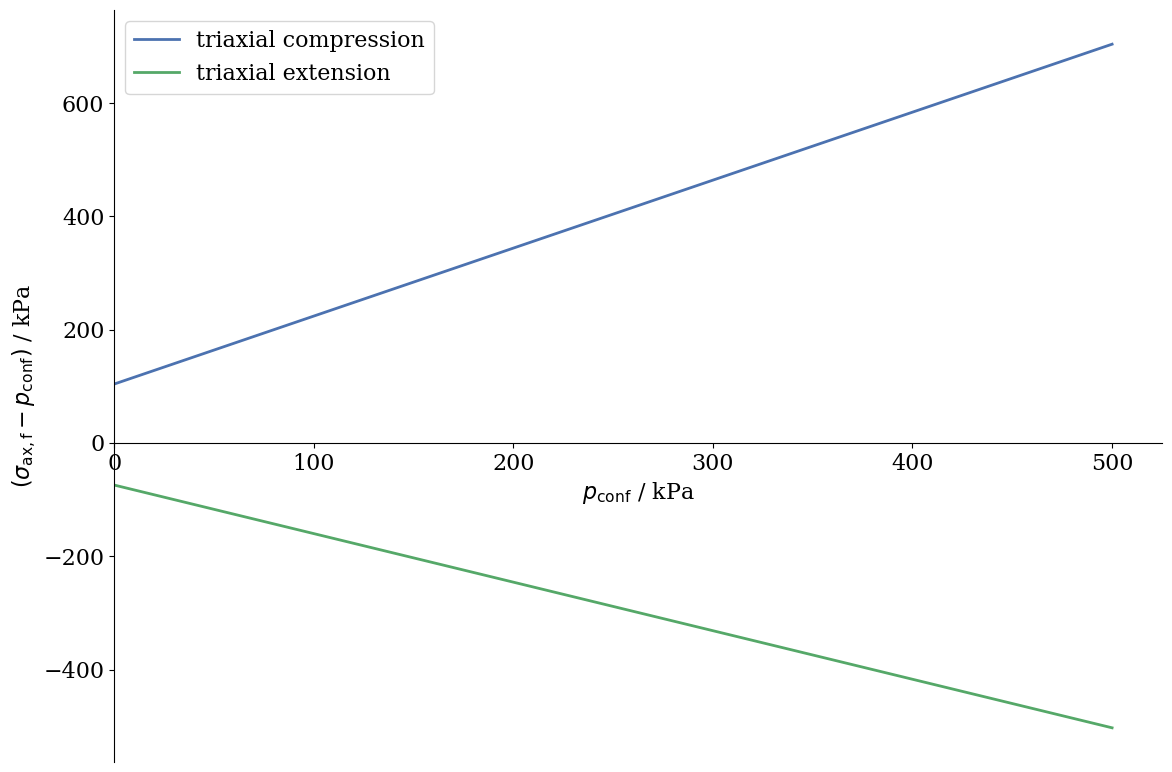

In [12]:
#HIDDEN
pconf = np.linspace(0,500,10)
q_triax_comp = lambda phi, c, pc: 6 * (pc * np.sin(phi) + c * np.cos(phi))/(3-np.sin(phi))
q_triax_ext = lambda phi, c, pc: - 6 * (pc * np.sin(phi) + c * np.cos(phi))/(3+np.sin(phi))
fig, ax = plt.subplots(figsize=(12,8))
ax.plot(pconf,q_triax_comp(np.deg2rad(30),50,pconf),label='triaxial compression')
ax.plot(pconf,q_triax_ext(np.deg2rad(30),50,pconf),label='triaxial extension')
ax.set_xlim(left=0)
ax.set_ylabel('$(\sigma_\\mathrm{ax,f} - p_\\mathrm{conf})$ / kPa')
ax.set_xlabel('$p_\\mathrm{conf}$ / kPa')
ax.spines['bottom'].set_position(('data', 0))
ax.legend()
fig.tight_layout()

Thus, we find an alternative formulation of the Mohr-Coulomb yield function $f$ in the $p-q$ space (only allowing triaxial compression or extension configurations):

$$
      f_\text{comp/ext} = q - \frac{6 \sin \varphi}{3 \mp \sin \varphi} p + \frac{6 c \cos \varphi}{3 \mp \sin \varphi} \leq 0
$$

**Remark:** In general stress states, the Mohr-Coulomb model needs to be formulated in $p-q-\theta_c$ space, where the Lode angle $\theta_c$

\begin{align}
    \theta_c &= \frac{1}{3}\arccos \left[ \frac{J_3}{2} \left( \frac{3}{J_2} \right)^{\frac{3}{2}} \right] \quad \text{with} \quad J_2 = \frac{q^2}{3},\ J_3 = \det \sigma_{ij}^\text{D}
    \\
    &= \frac{1}{3}\arccos \left[ \frac{27}{2} \left( \frac{J_3}{q^3} \right) \right]
\end{align}

distinguishes different loading configurations in terms of triaxiality (the position of the stress state in the deviatoric plane). For the investigated cases we find:

In [13]:
J3 = sp.det(sigD)
display(sp.simplify(J3.subs(s2,s3)/q_comp**3*27/2).factor())
display(sp.simplify(J3.subs(s2,s1)/q_ext**3*27/2).factor())

    σ₁ - σ₃    
───────────────
   ____________
  ╱          2 
╲╱  (σ₁ - σ₃)  

  -(σ₁ - σ₃)   
───────────────
   ____________
  ╱          2 
╲╱  (σ₁ - σ₃)  

The arguments are $\pm 1$ for compression and extension, respectively. Thus, 

$$
    \theta_c = \begin{cases}
        0 & \text{triax. compr.}
        \\\\
        \pi / 3 & \text{triax. ext.}
    \end{cases}
$$

**Note:** The definition of the Lode angle is not unique. Neither are it's limits.

### Flow rule

The Mohr-Coulomb model is usually employed with a non-associated flow rule based on a plastic potential involving the angle $\psi$ controlling dilatancy (the associated case would follow from $\varphi = \psi$). Let's depart again from a formulation written in axial and confining stresses:

$$
    g = \sigma_\text{ax} - \begin{cases}
        \displaystyle \frac{1 + \sin \psi}{1 - \sin \psi} p_\text{conf} & \text{triax. compr.}
        \\\\
        \displaystyle \frac{1 - \sin \psi}{1 + \sin \psi} p_\text{conf} & \text{triax. ext.}
    \end{cases}
$$

Plastic flow in the axial and "radial" directions follows from

\begin{align}
    \dot\epsilon_\text{ax}^\text{pl} &= \dot{\lambda} \frac{\partial g}{\partial \sigma_\text{ax}} = \dot\lambda
    \\
    \dot\epsilon_\text{rad}^\text{pl} &= \dot{\lambda} \frac{\partial g}{\partial p_\text{conf}} = -\dot\lambda \displaystyle \frac{1 \pm \sin \psi}{1 \mp \sin \psi}
\end{align}

The material flows into the direction of the axial stress change (compression or extension) and to a varying degree against the confining pressure (dilatancy effect).

The angle between radial and axial flow is thus

$$
    \frac{\dot\epsilon_\text{rad}^\text{pl}}{\dot\epsilon_\text{ax}^\text{pl}} = - \frac{1 \pm \sin \psi}{1 \mp \sin \psi} = \tan^2\left( \frac{\pi}{4} \pm \frac{\psi}{2} \right)
$$

We recognize the similarity to the results obtained for the active and passive slip planes (where we had studied the associated case).

We can look at the same concept using a $p-q$ formulation:

$$
    g_\text{comp/ext} = q - \frac{6 \sin \psi}{3 \mp \sin \psi} p
$$

The material will flow deviatorically and volumetrically:

\begin{align}
    \dot\epsilon_\text{dev}^\text{pl} &= \dot \lambda \frac{\partial g}{\partial q} = \dot \lambda
    \\
    \dot\epsilon_\text{vol}^\text{pl} &= \dot \lambda \frac{\partial g}{\partial p} = -\dot \lambda \frac{6 \sin \psi}{3 \mp \sin \psi}
\end{align}

Thus, for $\psi = 0°$ there will be no volume change (only isochoric plastic deformations). For a given dilatancy angle, the plastic volume strain rate depends on the loading configuration (Lode angle).

## Numerical simulation of simple stress paths -- Mohr-Coulomb

For the following, we're using MFront and OpenGeoSys. The main references are:

Helfer, T., Bleyer, J., Frondelius, T., Yashchuk, I., Nagel, T., & Naumov, D. (2020). The MFrontGenericInterfaceSupport project. Journal of Open Source Software, 5(48), 2003. https://doi.org/10.21105/joss.02003

Marois, G., Nagel, T., Naumov, D., & Helfer, T. (2020). Invariant-based implementation of the Mohr-Coulomb elasto-plastic model in OpenGeoSys using MFront. https://doi.org/10.13140/RG.2.2.34335.10403

### Triaxial tests

We start by simulating triaxial compression and extension tests.

In [14]:
c = 50e3
phi = 30
psi = 10
E = 50e6
nu = 0.25
times = np.append(np.linspace(0,1,10),np.linspace(1.01,2,19))

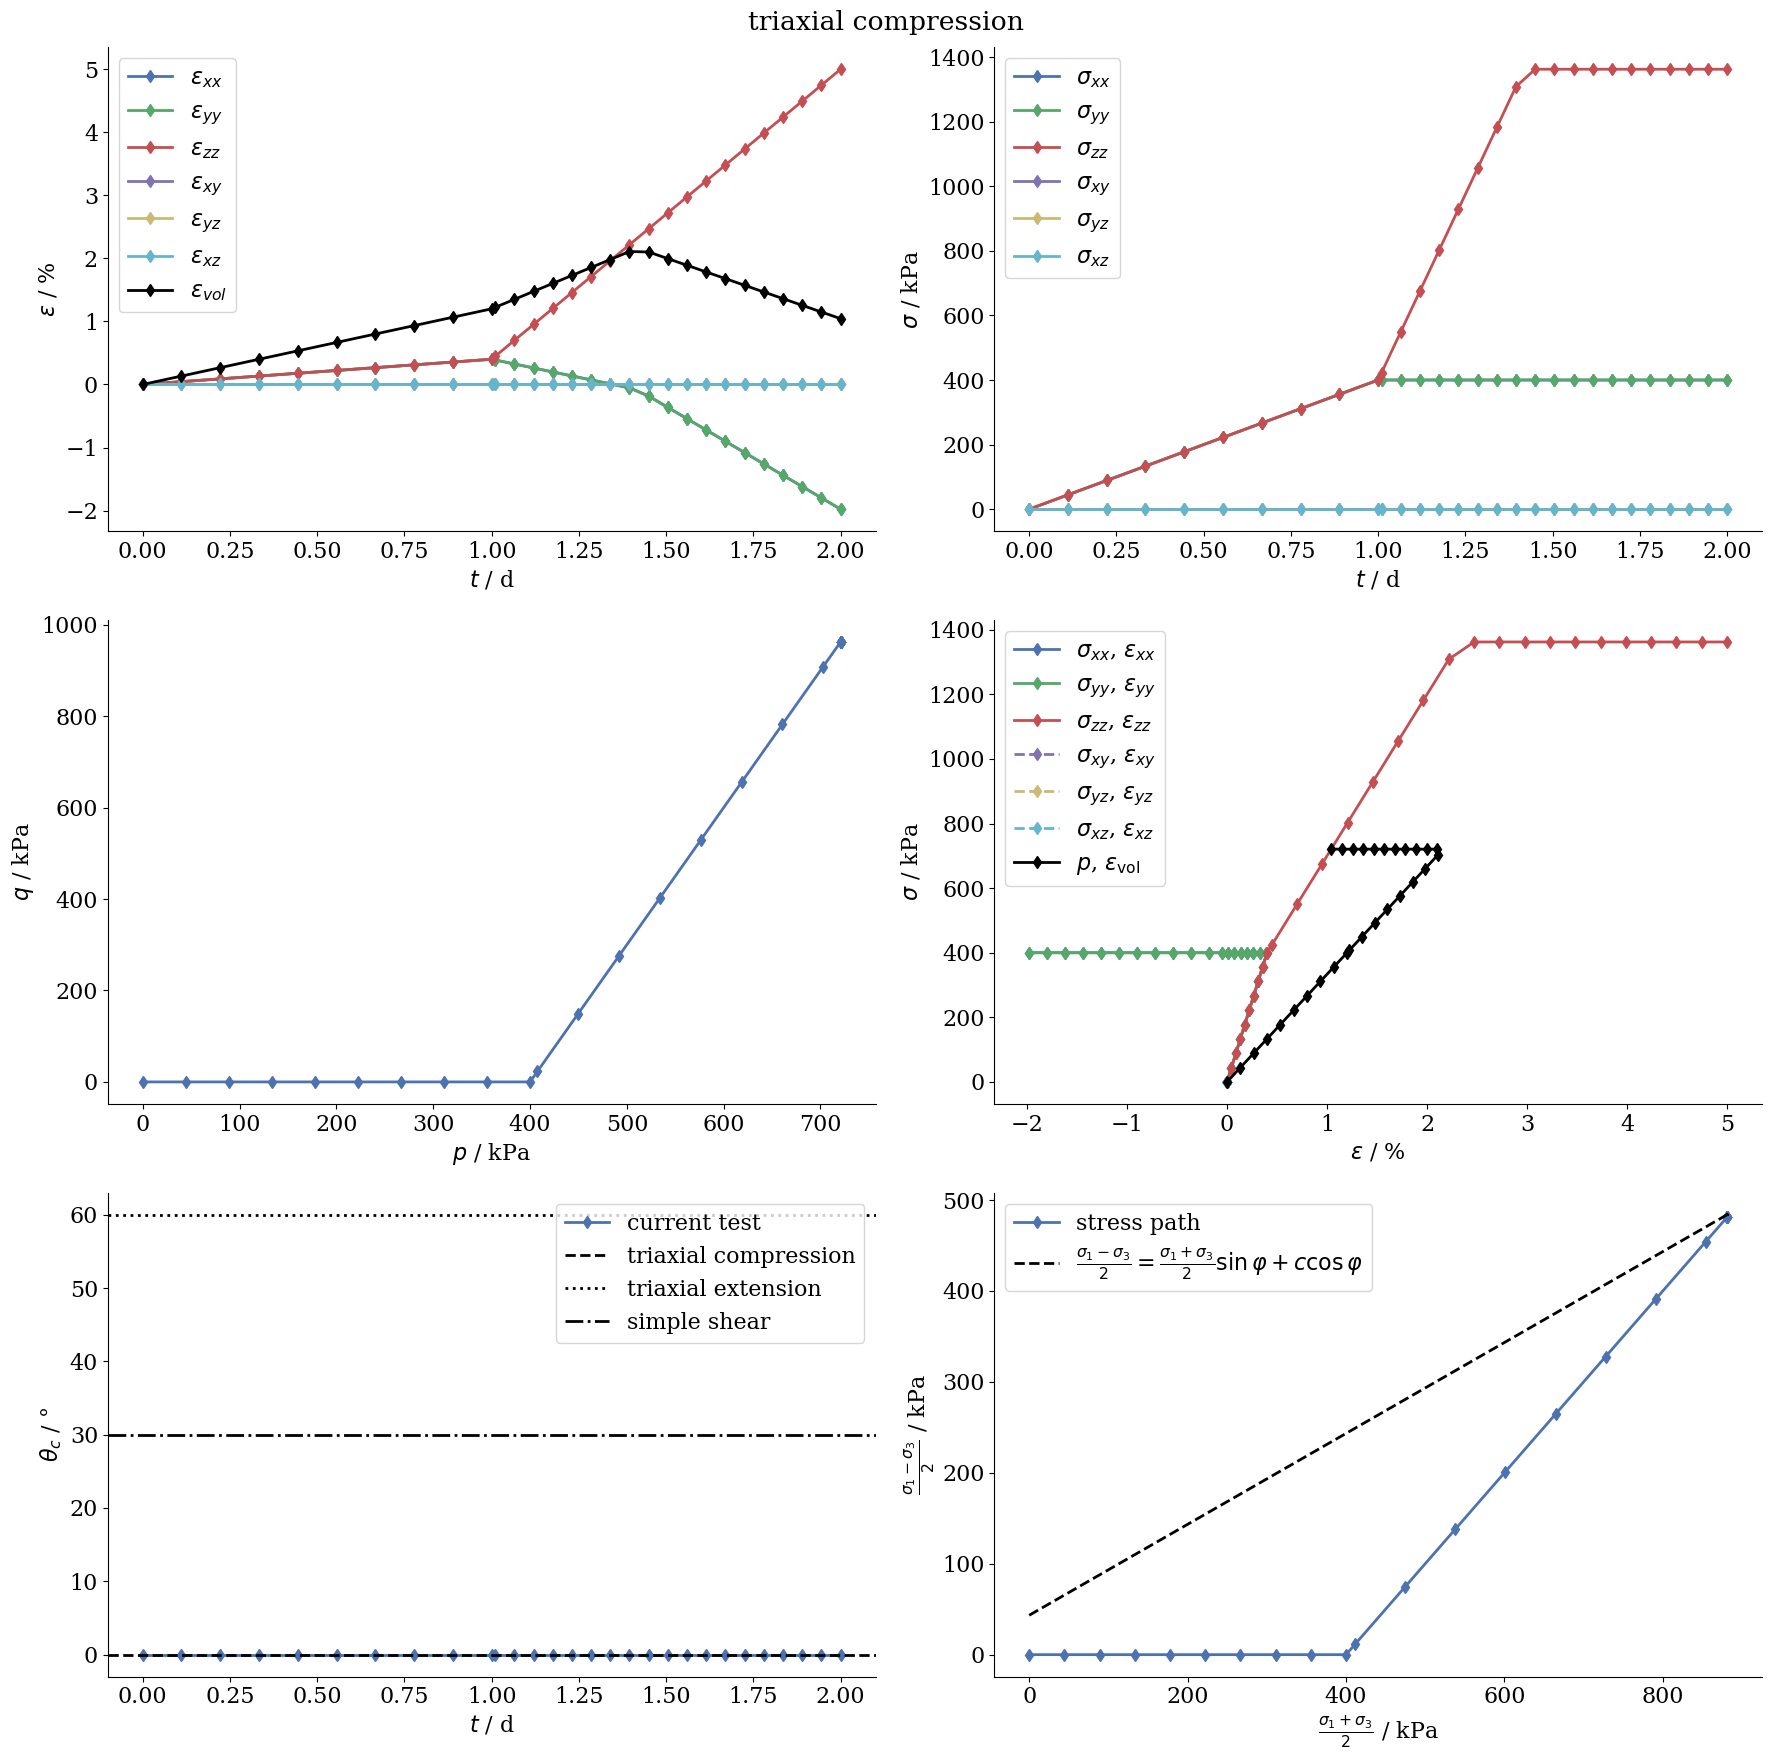

In [15]:
#HIDDEN
#%run stress_path_defs.ipynb
sig_xx, eps_xx, sig_yy, eps_yy, sig_zz, eps_zz, tau_xy, eps_xy, tau_xz, eps_xz, tau_yz, eps_yz = set_up_triax_test(E,nu,c,phi,psi,400e3,5e-2,times)
plot_results(sig_xx, eps_xx, sig_yy, eps_yy, sig_zz, eps_zz, tau_xy, eps_xy, tau_xz, eps_xz, tau_yz, eps_yz, 'triaxial compression')

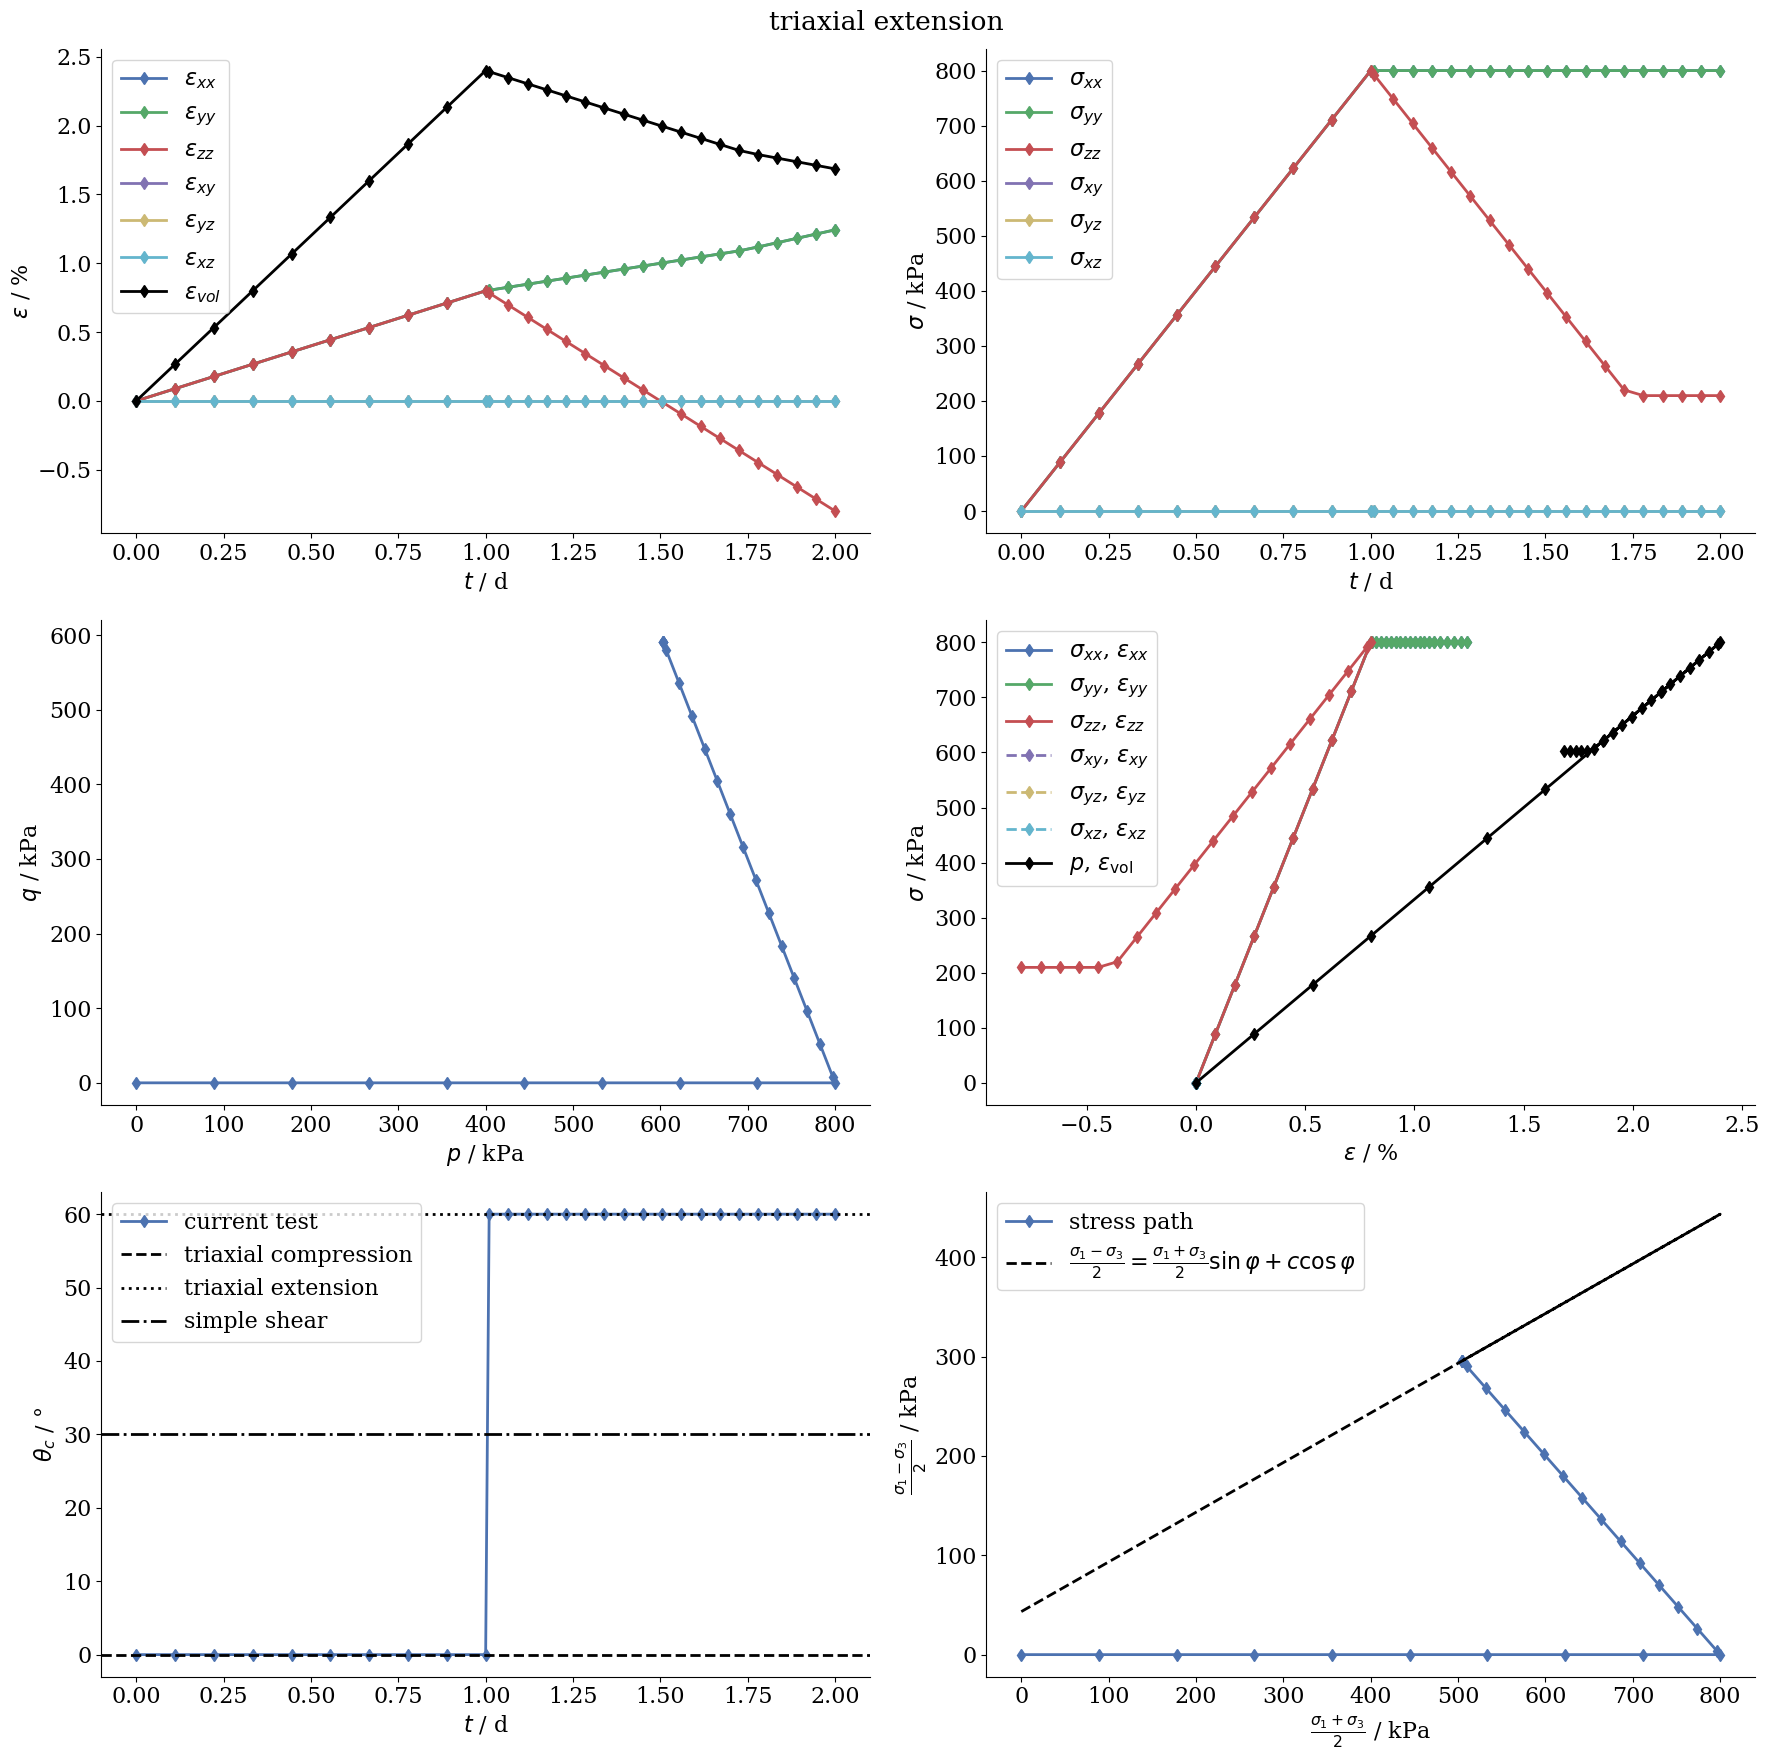

In [16]:
#HIDDEN
#%run stress_path_defs.ipynb
sig_xx, eps_xx, sig_yy, eps_yy, sig_zz, eps_zz, tau_xy, eps_xy, tau_xz, eps_xz, tau_yz, eps_yz = set_up_triax_test_ext(E,nu,c,phi,psi,800e3,times)
plot_results(sig_xx, eps_xx, sig_yy, eps_yy, sig_zz, eps_zz, tau_xy, eps_xy, tau_xz, eps_xz, tau_yz, eps_yz, 'triaxial extension')

### Shear box

We now simulate a shear box test using different assumptions regarding lateral confinement. Note, that due to differential normal stresses this is not a simple shear test (see lecture notes from "Mechanical Properties of Loose Rocks / Granular Media").

In [17]:
sig_ax = -100.e3

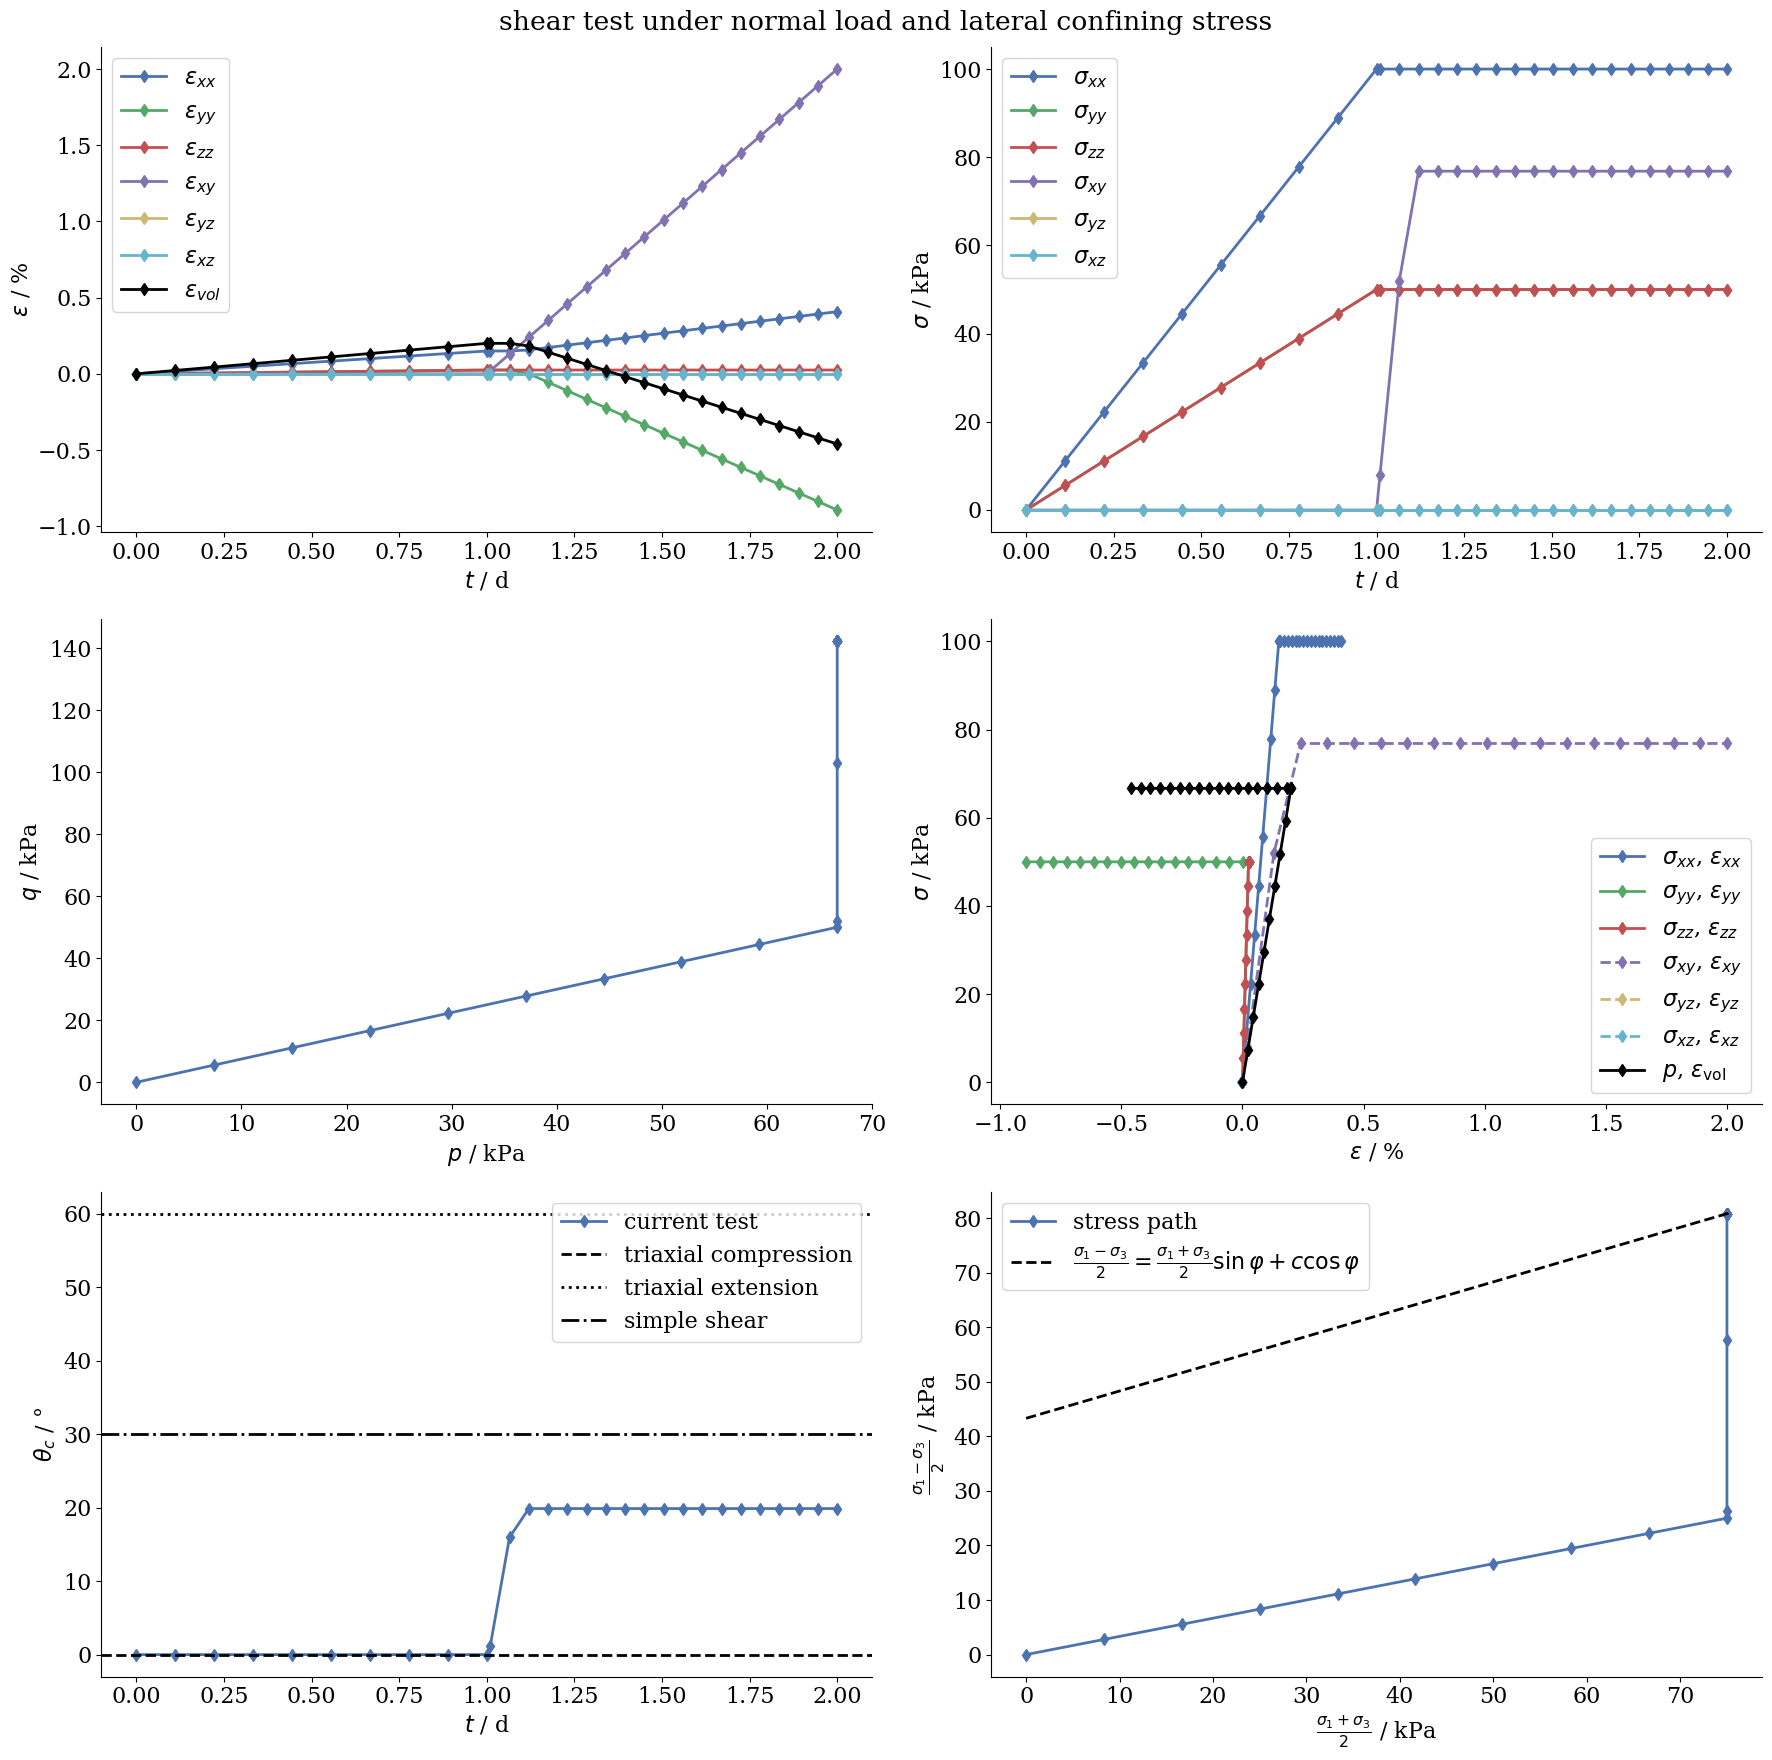

In [18]:
#HIDDEN
sig_xx, eps_xx, sig_yy, eps_yy, sig_zz, eps_zz, tau_xy, eps_xy, tau_xz, eps_xz, tau_yz, eps_yz = set_up_shear_test(E,nu,c,phi,psi,sig_ax,False,times)
plot_results(sig_xx, eps_xx, sig_yy, eps_yy, sig_zz, eps_zz, tau_xy, eps_xy, tau_xz, eps_xz, tau_yz, eps_yz, 'shear test under normal load and lateral confining stress')

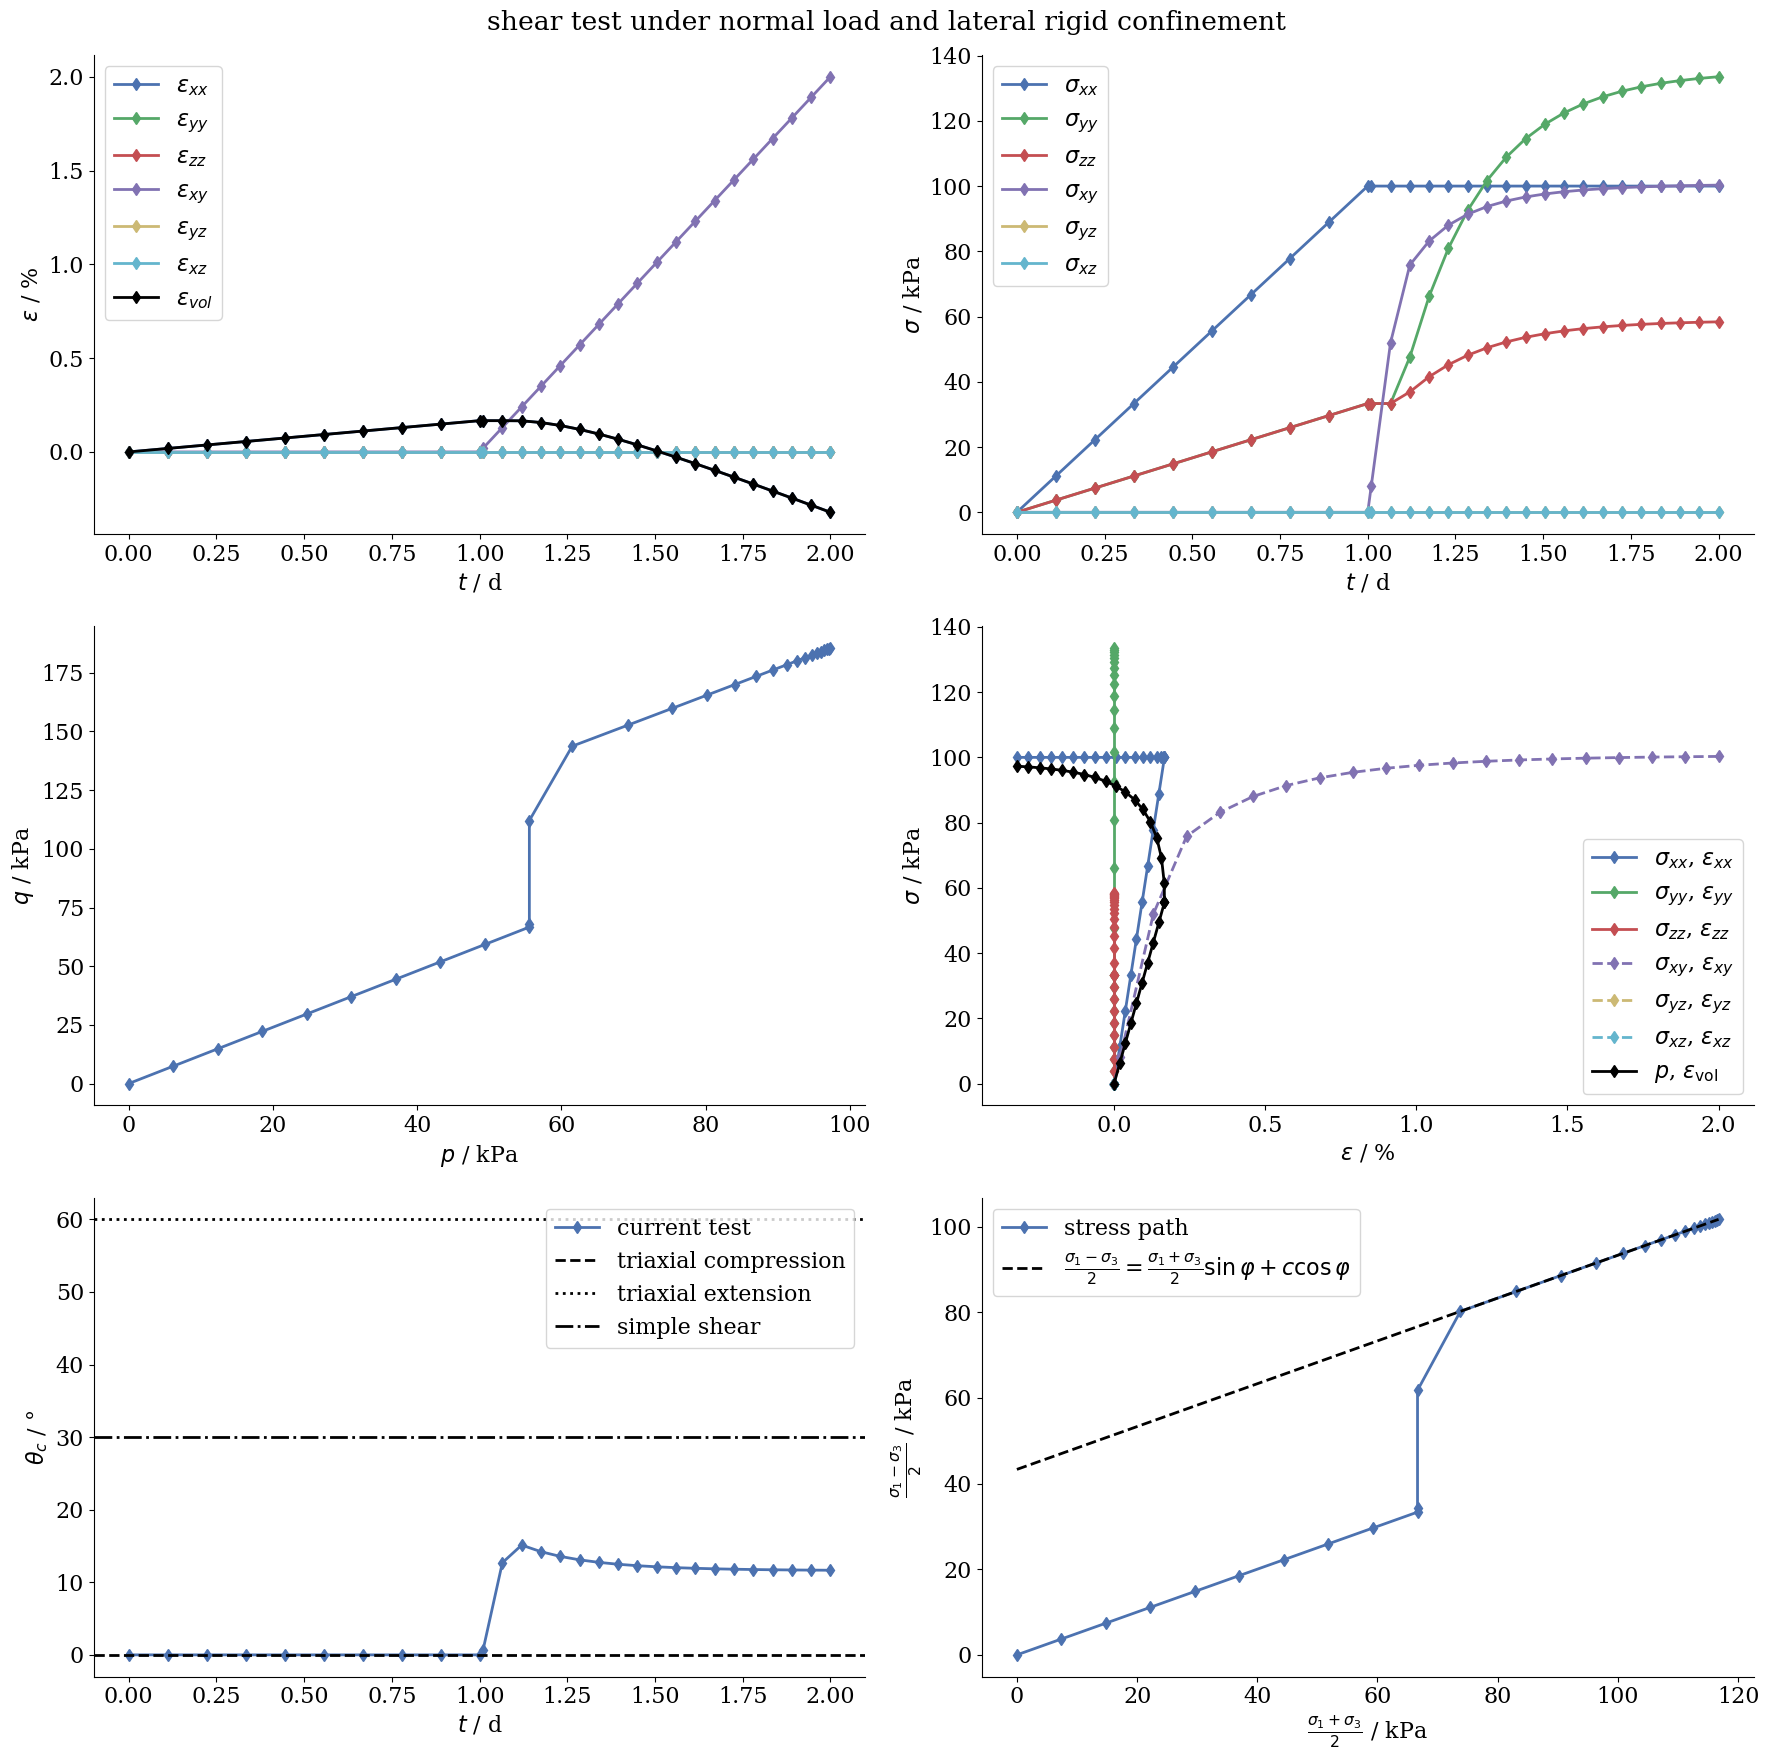

In [19]:
#HIDDEN
sig_xx, eps_xx, sig_yy, eps_yy, sig_zz, eps_zz, tau_xy, eps_xy, tau_xz, eps_xz, tau_yz, eps_yz = set_up_shear_test(E,nu,c,phi,psi,sig_ax,True,times)
plot_results(sig_xx, eps_xx, sig_yy, eps_yy, sig_zz, eps_zz, tau_xy, eps_xy, tau_xz, eps_xz, tau_yz, eps_yz, 'shear test under normal load and lateral rigid confinement')

## The Modified Cam-Clay model

For various reasons we use a slightly modified version of the MCC model, see here:

Silbermann, C., Nagel, T. (2020). Implementation of the modified Cam Clay model in MFront/OpenGeoSys.
https://www.opengeosys.org/docs/benchmarks/small-deformations/ModifiedCamClay_report.pdf

The MCC model is an associated elasto-plastic model ($f=g$) with an ellipsoidal yield condition / plastic potential for cohesionless materials:

$$
    f = g = q^2 - M^2 \left[ p (p_c - p) \right]
$$

There's no dependence on the Lode angle, so triaxiality is not considered (the cross section of the yield surface is a circle in the deviatoric plane). Plotting the surface reveals the role of $p_c$ as an isotropic pre-consolidation pressure and $M$ as the slope of the critical state line.

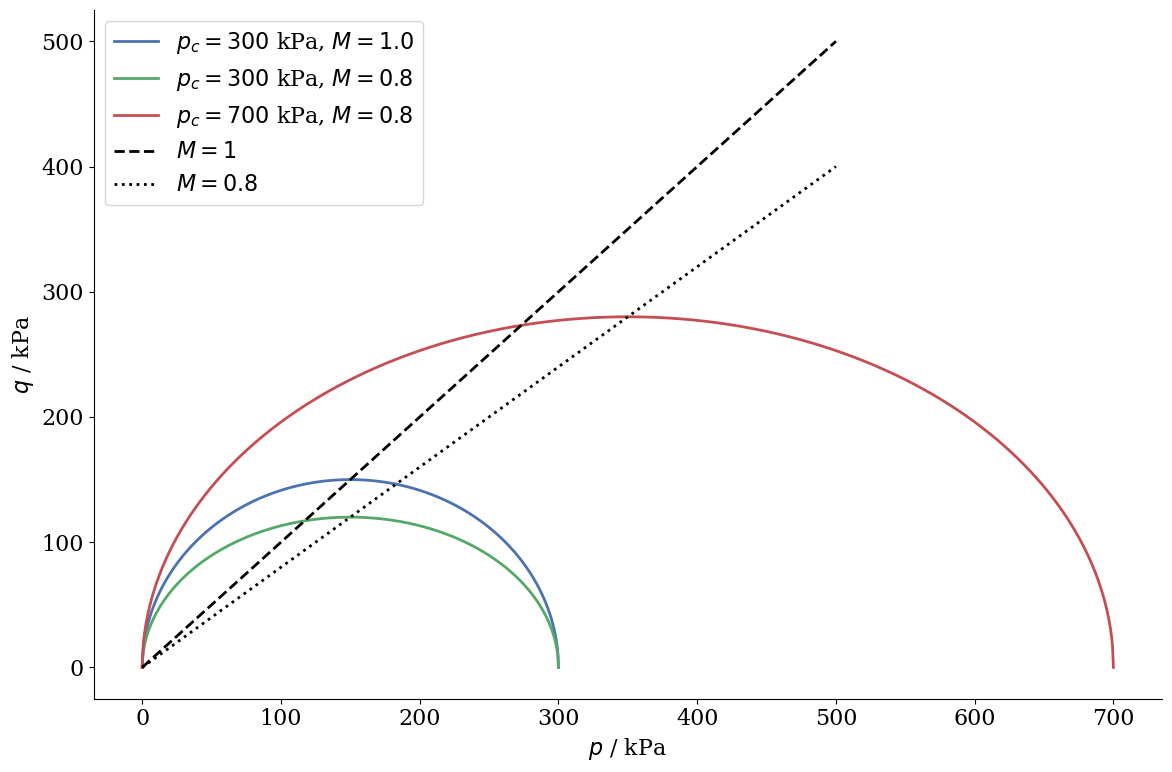

In [20]:
#HIDDEN
q = lambda p, pc, M: np.sqrt(M*M * (p * (pc - p)))
CSL = lambda p,M: M*p

fig, ax = plt.subplots(figsize=(12,8))
p = np.linspace(0,300,1000)
ax.plot(p,q(p,300,1.0),label='$p_c = 300$ kPa, $M = 1.0$')
ax.plot(p,q(p,300,0.8),label='$p_c = 300$ kPa, $M = 0.8$')
p = np.linspace(0,700,1000)
ax.plot(p,q(p,700,0.8),label='$p_c = 700$ kPa, $M = 0.8$')
p = np.linspace(0,500,1000)
ax.plot(p,CSL(p,1.0),color='black',ls='--',label='$M = 1$')
ax.plot(p,CSL(p,0.8),color='black',ls=':',label='$M = 0.8$')
ax.legend()
ax.set_xlabel('$p$ / kPa')
ax.set_ylabel('$q$ / kPa')
fig.tight_layout();

Let's look at plastic flow for a fixed pre-consolidation pressure (the non-standard units here are one reason we modified the formulation).

\begin{align}
    \dot\epsilon_\text{dev}^\text{pl} &= \dot \lambda \frac{\partial g}{\partial q} = 2 \dot \lambda q
    \\
    \dot\epsilon_\text{vol}^\text{pl} &= \dot \lambda \frac{\partial g}{\partial p} = -\dot \lambda M^2 (p_c - 2 p)
\end{align}

We observe that the plastic volume strain vanishes for $p = p_c/2$ and flow becomes purely deviatoric, which is one determinant of the critical state. We also observe, that for pressures $p < p_c/2$ flow is dilatant and for $p > p_c/2$ flow is contractant. For $p = p_c$ we have isotropic consolidation, i.e. no deviatoric flow but plastic compaction.

Another important ingredient is the hardening/softening rule:

$$
    \dot{p}_c = p_c \frac{1+e}{\lambda - \kappa} \dot{\epsilon}_\text{vol}^\text{pl}
$$

With $p_c \geq 0$, $\lambda - \kappa \geq 0$ we find that contractant flow leads to hardening (an expansion of the yield surface) and dilatant flow to softening (contraction of the yield surface). Note again, that the sign conventions regarding stresses and strains vary from publication to publication. More details can be found in Schmidt et al. 2017 (see lecture notes).

## Numerical simulation of simple stress paths -- Modified Cam-Clay

For the following, we're using MFront and OpenGeoSys. The main references are:

Helfer, T., Bleyer, J., Frondelius, T., Yashchuk, I., Nagel, T., & Naumov, D. (2020). The MFrontGenericInterfaceSupport project. Journal of Open Source Software, 5(48), 2003. https://doi.org/10.21105/joss.02003

Silbermann, C., Nagel, T. (2020). Implementation of the modified Cam Clay model in MFront/OpenGeoSys.
https://www.opengeosys.org/docs/benchmarks/small-deformations/ModifiedCamClay_report.pdf

In [21]:
nu = 0.25  # Poisson ratio
E = 50.0e6  # Young's modulus in Pa
la = 7.7e-2  # slope of the virgin consolidation line
ka = 6.6e-3  # slope of the swelling line
M = 1.2  # slope of the critical state line (CSL)
v0 = 1.788  # initial volume ratio
phi0 = 1 - 1 / v0  # Initial porosity
pc0 = 800.0e3  # Initial pre-consolidation pressure in Pa
pamb = 1.0  # Ambient pressure in Pa

times = np.linspace(0,1,20)

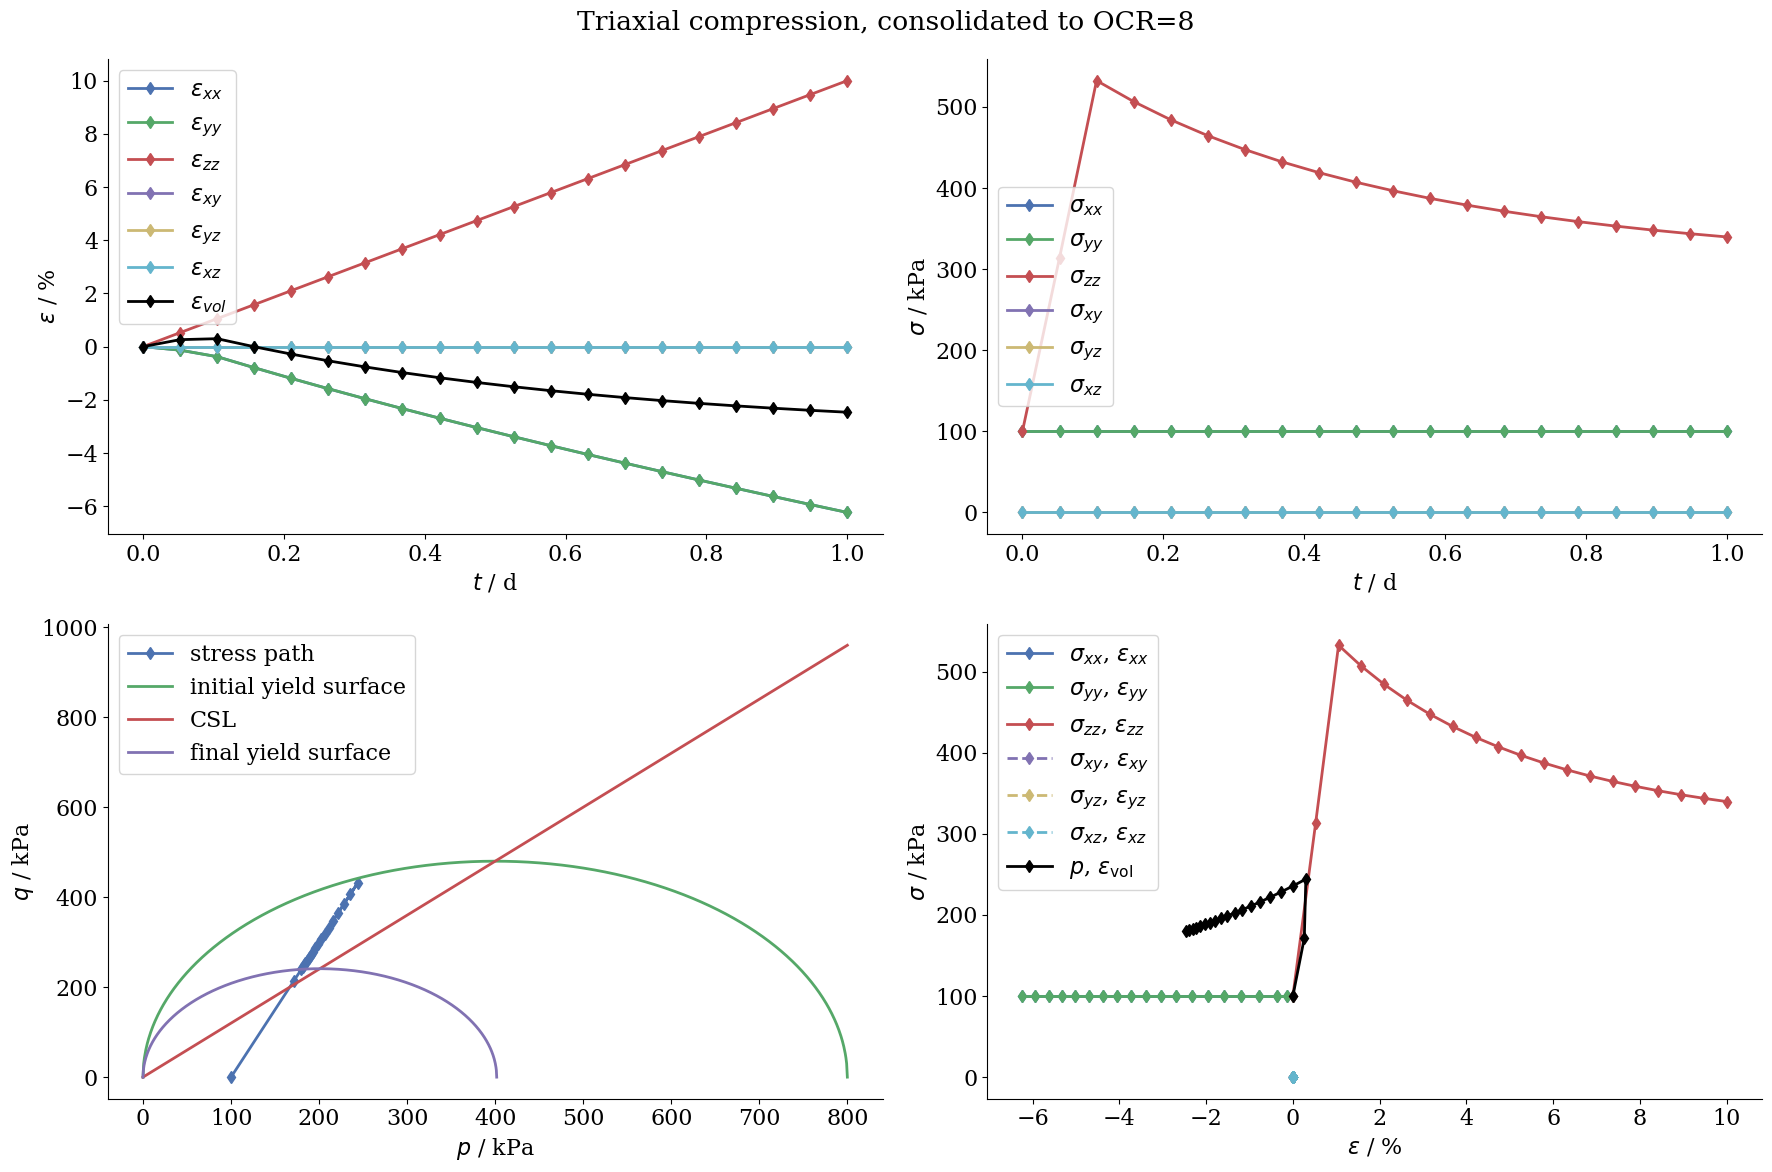

In [22]:
#HIDDEN
#%run stress_path_defs.ipynb
sig_xx, eps_xx, sig_yy, eps_yy, sig_zz, eps_zz, tau_xy, eps_xy, tau_xz, eps_xz, tau_yz, eps_yz, pc, vr = MCC_triax_test(E,nu,la,ka,M,v0,phi0,pc0,pamb,100e3,10e-2,times)
plot_results_MCC(sig_xx, eps_xx, sig_yy, eps_yy, sig_zz, eps_zz, tau_xy, eps_xy, tau_xz, eps_xz, tau_yz, eps_yz, pc, vr, M, 'Triaxial compression, consolidated to OCR=8')

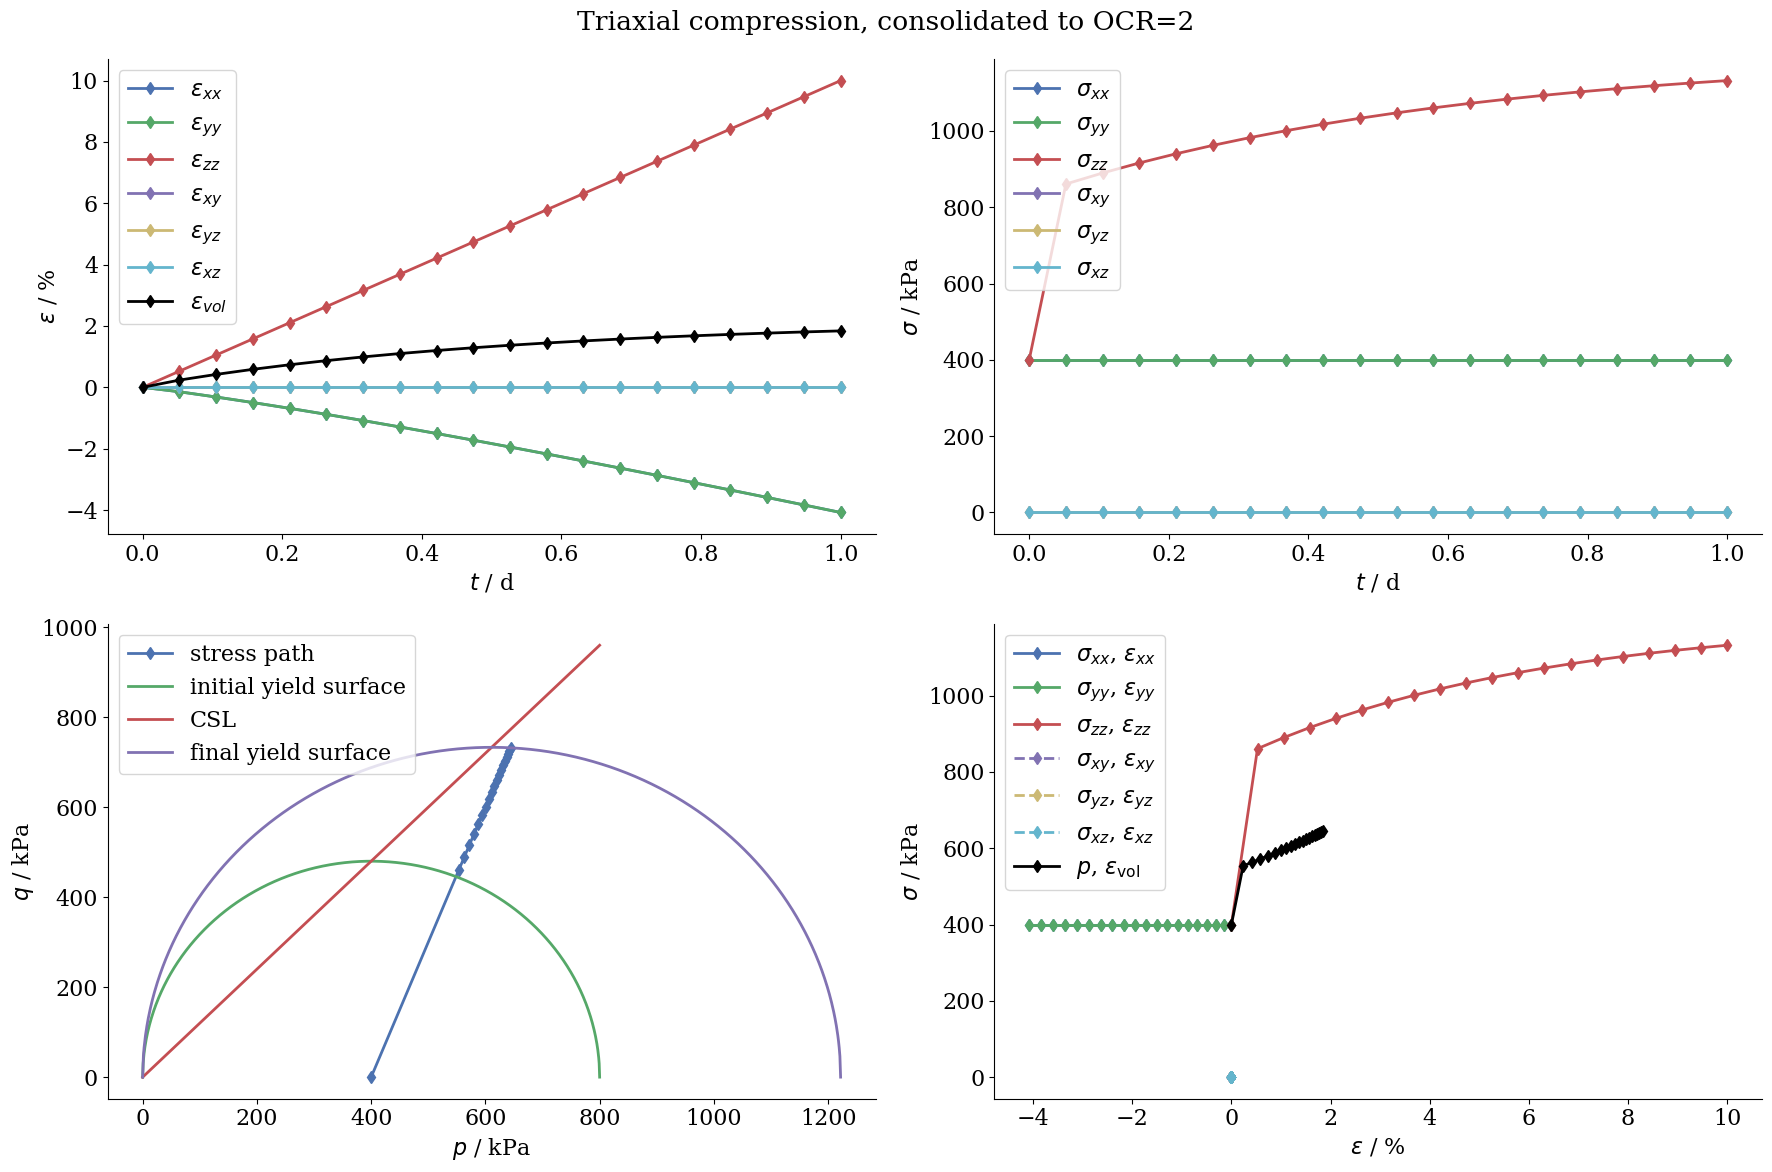

In [23]:
#HIDDEN
#%run stress_path_defs.ipynb
times = np.linspace(0,1,20)
sig_xx, eps_xx, sig_yy, eps_yy, sig_zz, eps_zz, tau_xy, eps_xy, tau_xz, eps_xz, tau_yz, eps_yz, pc, vr = MCC_triax_test(E,nu,la,ka,M,v0,phi0,pc0,pamb,400e3,10e-2,times)
plot_results_MCC(sig_xx, eps_xx, sig_yy, eps_yy, sig_zz, eps_zz, tau_xy, eps_xy, tau_xz, eps_xz, tau_yz, eps_yz, pc, vr, M, 'Triaxial compression, consolidated to OCR=2')

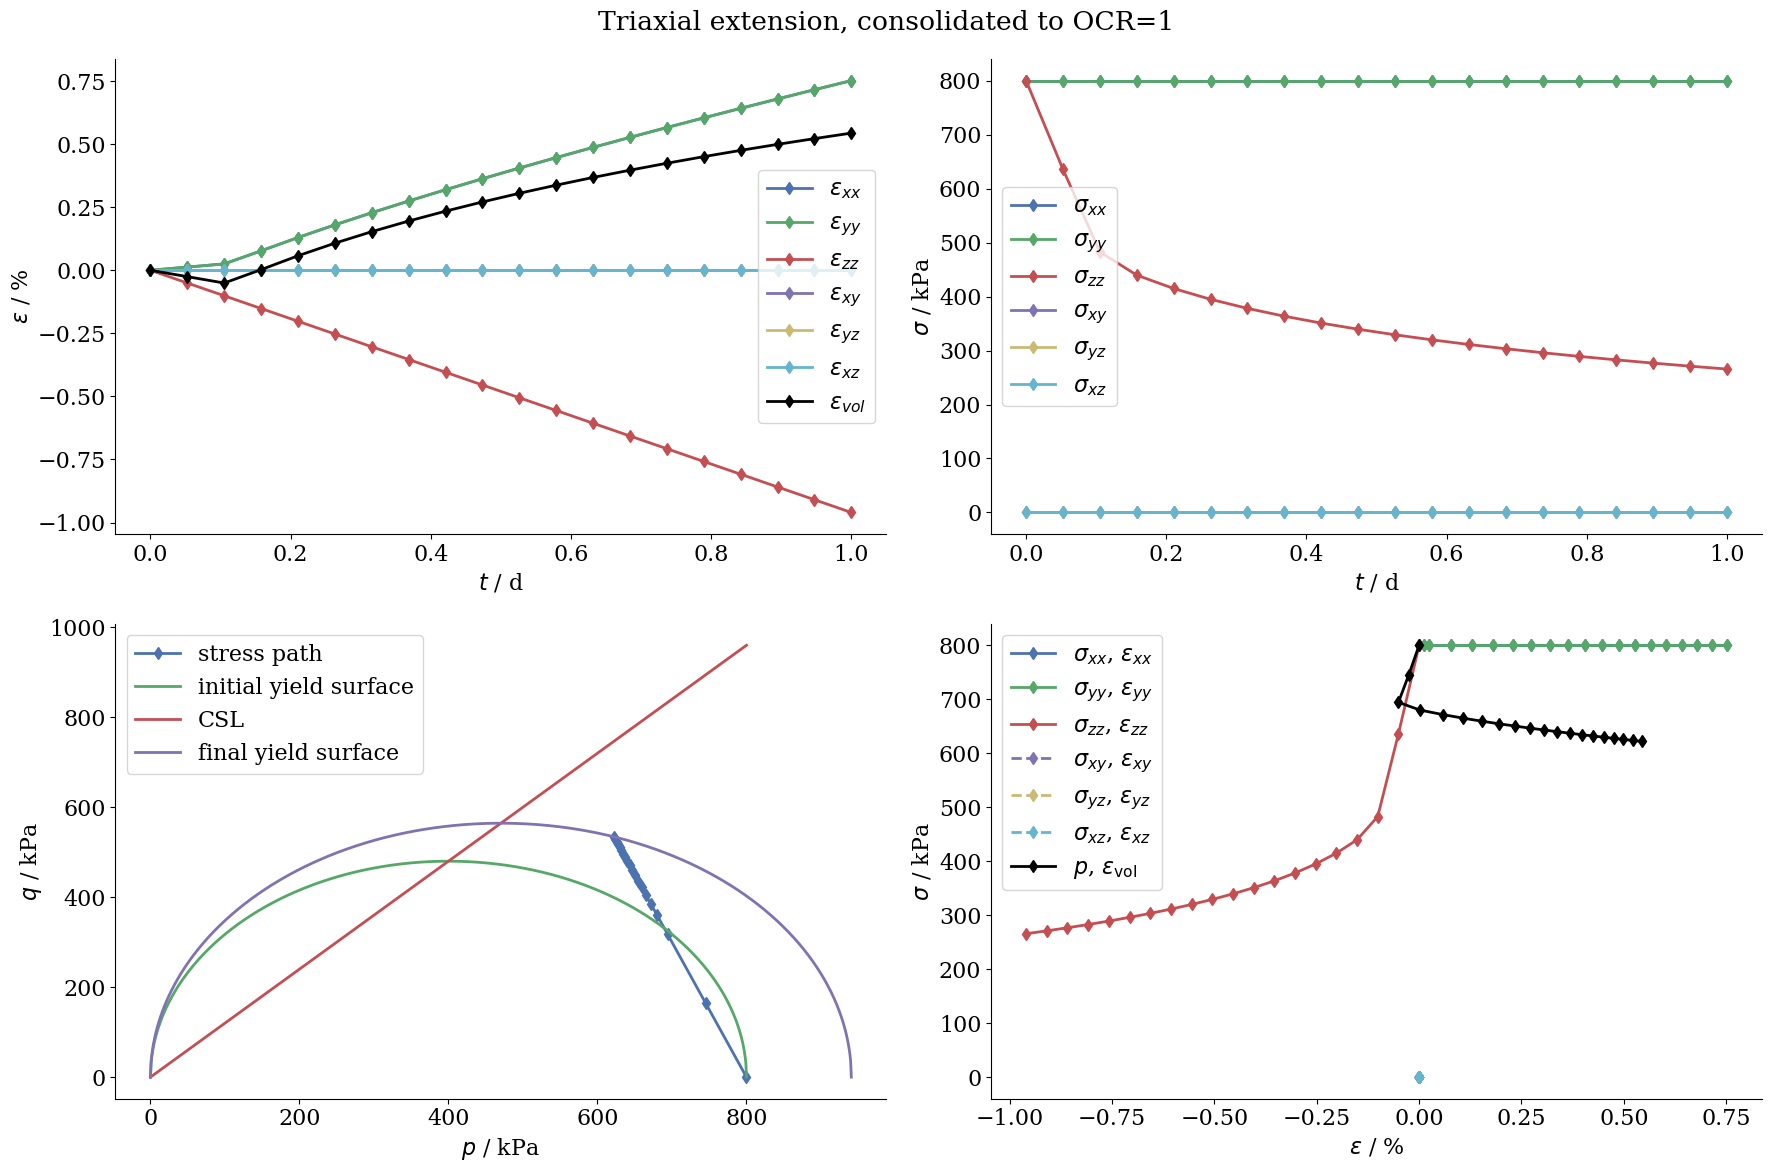

In [24]:
#HIDDEN
#%run stress_path_defs.ipynb
sig_xx, eps_xx, sig_yy, eps_yy, sig_zz, eps_zz, tau_xy, eps_xy, tau_xz, eps_xz, tau_yz, eps_yz, pc, vr = MCC_triax_test_ext(E,nu,la,ka,M,v0,phi0,pc0,pamb,800e3,times)
plot_results_MCC(sig_xx, eps_xx, sig_yy, eps_yy, sig_zz, eps_zz, tau_xy, eps_xy, tau_xz, eps_xz, tau_yz, eps_yz, pc, vr, M, 'Triaxial extension, consolidated to OCR=1')